# 05d Bias magnitudes with atm effects order 0, Preselect good PZ and apply atmospheric effects

- author Sylvie Dagoret-Campagne
- creation date : 2024/03/22
- last verification : 2024/03/22

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import copy

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import getpass
import datetime

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
props = dict(boxstyle='round', facecolor='yellow', alpha=0.3)

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [2]:
from scipy import interpolate
from astropy import constants as const
from astropy import units as u
from joblib import dump, load
import pickle

In [3]:
import warnings                      # imports the warnings library
import gc                            # imports python's garbage collector
# Ignore warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

In [7]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

LSST site name validated as LSST observatory


In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [9]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [10]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [11]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [12]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [13]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [14]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

## Chose a Standard atmosphere

In [15]:
am0 =1.20    # airmass
pwv0 = 2.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.0 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0 # Aerosol Angstrom exponent

In [16]:
am0 =1.20    # airmass
pwv = 10.0  # Precipitable water vapor vertical column depth in mm
oz = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau= 0.0 # Vertical Aerosol depth (VAOD) 
beta = 1.0 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [17]:
pc0 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc = PhotometricCorrections(am0,pwv,oz,tau,beta)

/pbs/throng/lsst/users/dagoret/desc/2024/AtmosphericStuffs/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [18]:
delta_y = -2.5*np.log10(pc0.all_II0_std["y"]/pc.all_II0_std["y"])

In [19]:
delta_u = -2.5*np.log10(pc0.all_II0_std["u"]/pc.all_II0_std["u"])

In [20]:
delta_u

-1.1092360255736664e-07

In [21]:
delta_y

-0.15664929386380202

### Check standard atmosphere

Text(0.5, 1.0, 'Standard and atmosphere transmission')

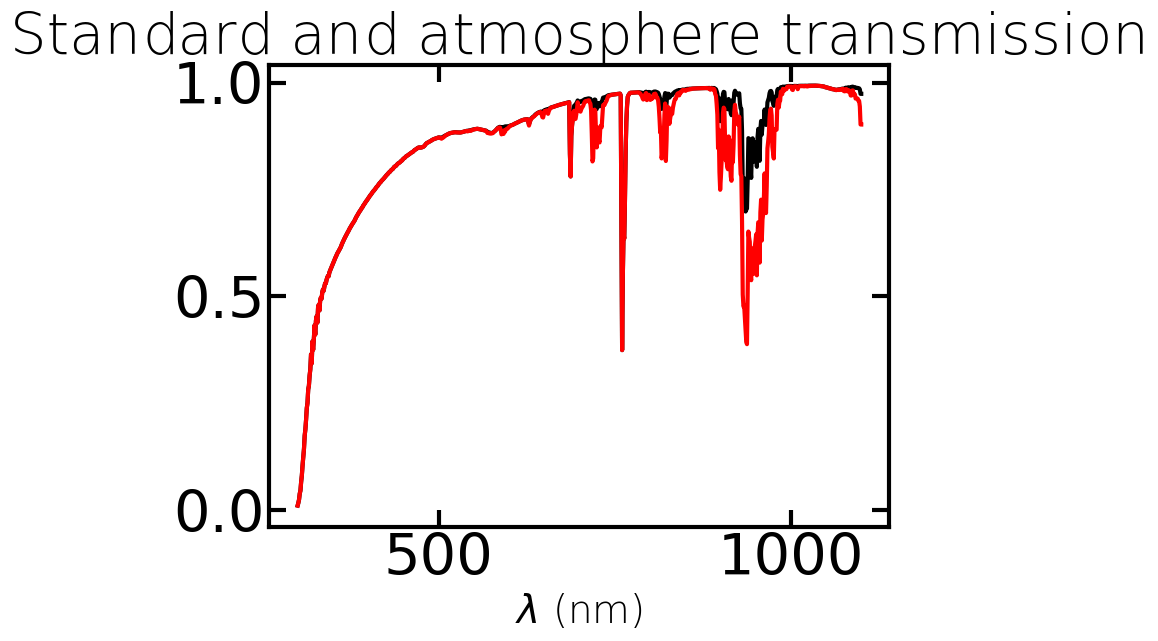

In [22]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.plot(pc0.WL,pc0.atm_std,'k-')
axs.plot(pc.WL,pc.atm_std,'r-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard and atmosphere transmission")


In [23]:
delta = {}
for ifilt,f in enumerate(filter_tagnames):
    delta[f] = -2.5*np.log10(pc0.all_II0_std[f]/pc.all_II0_std[f])

In [24]:
delta

{'u': -1.1092360255736664e-07,
 'g': -0.00019149576058064262,
 'r': -0.0025553588760383337,
 'i': -0.019765325045208212,
 'z': -0.0404157531220229,
 'y': -0.15664929386380202}

## Machine Learning

### Config

In [25]:
# temporary folders if necessary
NBDIR       = 'photoz_dp02'                            # relative path for this notebook output
TMPTOPDIR   = "/sps/lsst/groups/photoz/sylvie2024/from_MYDP0LSS"                               # always write some output in /scratch, never in user HOME 
TMPUSERDIR = TMPTOPDIR 
TMPNBDIR    = os.path.join(TMPUSERDIR,NBDIR)           # output path for this particular notebook
FLAG_READ_DATAFRAMEFROMDISK = True                     # must read data from disk

In [26]:
filename_result=f'fluxesredshift_result.pkl'
fullfilename_result=os.path.join(TMPNBDIR,filename_result)

In [27]:
# Show plots on redshift distribution
FLAG_SHOW_TRUE_REDSHIFT_DISTRIB = True

In [28]:
# Show plots to check the photometry selected for photoz
# For a pure demo on photoZ, this section can be skipped
FLAG_SHOW_PHOTOMETRY_DETECTION = True

### Start here

#### Read

In [29]:
if FLAG_READ_DATAFRAMEFROMDISK and os.path.exists(fullfilename_result):
    sql_results = pd.read_pickle(fullfilename_result)

In [30]:
data = sql_results

In [31]:
data.head()

,mt_id_truth_type,mt_match_objectId,ts_ra,ts_dec,ts_truth_type,ts_mag_r,ts_is_pointsource,ts_redshift,ts_flux_u,ts_flux_g,...,obj_r_cModelFlux,obj_i_cModelFlux,obj_z_cModelFlux,obj_y_cModelFlux,obj_u_cModelMag,obj_g_cModelMag,obj_r_cModelMag,obj_i_cModelMag,obj_z_cModelMag,obj_y_cModelMag
0,7939458371_1,1651413688361450903,61.842387,-36.524608,1,23.649401,0,0.951227,901.932007,893.604980,...,2062.920998,3226.156045,5167.702940,5953.202104,23.544281,23.413564,23.113794,22.628287,22.116756,21.963123
1,7940601535_1,1651413688361451151,61.887583,-36.523576,1,23.478600,0,1.142670,1177.569946,1248.369995,...,1555.517213,2007.930923,3577.964091,4435.082726,23.654670,23.553670,23.420313,23.143128,22.515910,22.282746
2,7938042672_1,1651413688361451083,61.949615,-36.527649,1,23.201700,0,0.576006,573.070984,878.140015,...,1943.691304,3379.122989,3879.091103,4958.231052,24.590838,24.023397,23.178432,22.577990,22.428175,22.161683
3,7937797456_1,1651413688361451150,61.887049,-36.525188,1,22.417500,0,0.442611,399.596985,1157.119995,...,4398.087847,6030.980909,6976.460761,7867.026482,25.030332,23.661947,22.291840,21.949030,21.790912,21.660473
4,7944880657_1,1651413688361451062,61.924857,-36.527904,1,24.007401,0,1.784890,648.911987,738.971008,...,752.674832,937.976640,1608.215672,2100.901486,24.924957,24.455480,24.208482,23.969520,23.384139,23.093986


In [32]:
del data['mt_id_truth_type']
del data['mt_match_objectId']
del data['ts_ra']
del data['ts_dec']
del data['ts_truth_type']
del data['ts_mag_r']
del data['ts_is_pointsource']
del data['ts_flux_u']
del data['ts_flux_g']
del data['ts_flux_r']
del data['ts_flux_i']
del data['ts_flux_z']
del data['ts_flux_y']
del data['obj_coord_ra'] 
del data['obj_coord_dec'] 
del data['obj_u_cModelFlux'] 
del data['obj_g_cModelFlux'] 
del data['obj_r_cModelFlux'] 
del data['obj_i_cModelFlux'] 
del data['obj_z_cModelFlux']
del data['obj_y_cModelFlux']

In [33]:
# for shorter names
data.rename(columns={"obj_u_cModelMag": "mag_u", "obj_g_cModelMag": "mag_g","obj_r_cModelMag": "mag_r",
                     "obj_i_cModelMag": "mag_i", "obj_z_cModelMag": "mag_z","obj_y_cModelMag": "mag_y",
                     "ts_redshift":"redshift"
                    },inplace=True)

In [34]:
data

,redshift,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0.951227,23.544281,23.413564,23.113794,22.628287,22.116756,21.963123
1,1.142670,23.654670,23.553670,23.420313,23.143128,22.515910,22.282746
2,0.576006,24.590838,24.023397,23.178432,22.577990,22.428175,22.161683
3,0.442611,25.030332,23.661947,22.291840,21.949030,21.790912,21.660473
4,1.784890,24.924957,24.455480,24.208482,23.969520,23.384139,23.093986
...,...,...,...,...,...,...,...
56173,1.181640,24.478454,24.677930,24.415583,24.230565,23.764589,23.400803
56174,0.701075,25.402165,24.514681,23.352261,22.587281,22.316529,22.082402
56175,0.714574,23.760397,23.768756,23.193998,22.345509,21.853552,21.621882
56176,0.824669,24.096307,23.557741,22.409664,21.378226,20.745974,20.503063


In [35]:
# drop NA
data = data.dropna()

In [36]:
len(data)

55564

In [37]:
pd.options.mode.chained_assignment = None  # default='warn'
data["umg"]=data["mag_u"]- data["mag_g"]
data["gmr"]=data["mag_g"]- data["mag_r"]
data["rmi"]=data["mag_r"]- data["mag_i"]
data["imz"]=data["mag_i"]- data["mag_z"]
data["zmy"]=data["mag_z"]- data["mag_y"]

# Machine Learning for Photo-Z estimation

# Requirements from LSST Science book:
(https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf)

Photometric redshifts for LSST will be applied and calibrated over the redshift range $0 < z < 4$
for galaxies to $r  \simeq 27.5$. 
For the majority of science cases, such as weak lensing and BAO, a subset
of galaxies with $i < 25.3$ will be used. For this high S/N gold standard subset over the
redshift interval, $0 < z < 3$, the photometric redshift requirements are:

- The root-mean-square scatter in photometric redshifts, $ \sigma_z/(1+z)$, must be smaller than 0.05, with a goal of 0.02.
- The fraction of $3\sigma $  outliers at all redshifts must be below 10%.
- The bias in $e_z = (z_{photo}−z_{spec})/(1+z_{spec})$ 
must be below 0.003 (or 0.01 for combined,analyses of weak lensing and baryon acoustic oscillations); 
- The uncertainty in  $\sigma_z/(1+z)$ must also be known to similar accuracy.



### other definitions

- **the photo-z accuracy is the absolute value of the difference between the true and photometric redshifts**.

-  **the photo-z uncertainty is the standard deviation of the true redshifts** 

In [38]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt
    

In [39]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot_and_stats(z_spec,z_phot):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    #------------------------
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.plot(x, outlier_upper, 'k--')
    plt.plot(x, outlier_lower, 'k--')
    plt.plot(z_spec[mask], z_phot[mask], 'r+', markersize=3,  alpha=0.1)
    plt.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=3, alpha=0.1)
    plt.plot(x, x, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 3])
    plt.ylim([0.0, 3])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [40]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot2_and_stats(z_spec,z_phot):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = 0.15
    outlier_lower = - 0.15

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    #------------------------
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.axhline(y=outlier_upper, ls="--",color='k')
    plt.axhline(y=outlier_lower, ls='--',color='k')
    plt.plot(z_spec[mask], (z_phot[mask]-z_spec[mask])/(1+z_spec[mask]), 'r+', markersize=3,  alpha=0.1)
    plt.plot(z_spec[notmask], (z_phot[notmask]-z_spec[notmask])/(1+z_spec[notmask]), 'b.',  markersize=3, alpha=0.1)
    plt.axhline(y=0, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 3])
    plt.ylim([-0.5, 0.5])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$\Delta z/(1+z)$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [41]:
target = data["redshift"]
features = data[["mag_u","mag_g","mag_r","mag_i","mag_z","mag_y"]]

In [42]:
Ntot = len(target)
Ntot

55564

### Split in training / test set

- speed of the notebook must be tuned with the training sample size

### number of samples to be used in training

- depending on the required speed of the demo 

In [43]:
Ntrain = 20000
Ntest = Ntot-Ntrain

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
# Test fraction
test_sample_size_fraction=Ntest/Ntot
test_sample_size_fraction

0.6400547116838241

In [46]:
# adapt the train dataset size according required running time 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)

### RandomForest regressor

- RandomForest regressor is an Enssemble regressor of type Bagging (Bootstrap and Aggregation).  

- RandomForest regressor combines the regression of multiple decision tree regressors fitted in parallel 
on bootstrapped samples from the training sample.

- Each individual decision tree is deep, meaning they individually overfit the bootstrapped samples. 

- The aggregation of the overfitting parallel decision tree model reduce the over-fitting.
- For Random Forest, each Decision Tree node feature are drawn randomly. This reduce the error correlation of the various trees.
- From this caracteristics, RandomForest is expected to be one of the best non-linear regressor on column-tabulated datasets.


- RandomForst includes a number of hyper-parameters.
- We use the hyper-parameters chosen byJeff Newmann for the DE-School at Oxford 2016.

In [47]:
from sklearn.ensemble import RandomForestRegressor
#randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30, max_features = 'auto')
randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30)

## Evaluation metrics

In [48]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer
scoring = {'r2': make_scorer(r2_score),'mae': make_scorer(mean_absolute_error),'mse': make_scorer(mean_squared_error)}

## Definition of the $R^2$ score for a regression (not a classification)

- see https://en.wikipedia.org/wiki/Coefficient_of_determination

- The R^2 score is also called the coefficient of determination

$$
R^2 = 1 - \frac{SSR}{SST} = \frac{SSE}{SST}
$$

where:

- $SST = \sum_i (y_i - \overline{y})^2$ , for total sum of squares,
- $SSR = \sum_i (y_i - \hat{y}_i)^2$ , for the residual sum of squares,
- $SSE = SST - SSR $, is the variance explained


The fit is good when $SSR \simeq 0$, thus when $R^2$ score is 1

- another interpretation is $R^2 = corr(y_i, \hat{y}_i)^2$

## NO Training

In [49]:
#%%time
# We simply use the fit method, not the cross_validate to accelerate the demo 
#t1 = datetime.datetime.now()
#randomforest_regressor.fit(X_train,y_train)
#t2 = datetime.datetime.now()
#deltat = (t2-t1).total_seconds() 
#print(f"RandomForest : elapsed time {deltat:.2f} sec")

## Read the model parameters

In [50]:
#filename_modelparams = 'randomforest_regressor.joblib'
filename_modelparams = 'randomforest_regressor_standardized.joblib'
regressor = load(filename_modelparams) 

## Estimate

In [51]:
y_pred =  regressor.predict(X_test)

In [52]:
zphot= y_pred
zspec = y_test

In [53]:
r2  = r2_score(y_pred,y_test)
mae = mean_absolute_error(y_pred,y_test)
mse = mean_squared_error(y_pred,y_test)

In [54]:
msg_r2   = f"R2 score : \t\t {r2:.3f}"
msg_mae  = f"MAE mean absolute error : \t {mae:.3f}"
msg_rmsq = f"Root MSE error : \t\t {np.sqrt(mse):.3f}"

In [55]:
print(msg_r2)
print(msg_mae)
print(msg_rmsq)

R2 score : 		 0.852
MAE mean absolute error : 	 0.092
Root MSE error : 		 0.186


### Performances

In [56]:
nmad,std_result,bias,eta,stats_txt2= get_stats(y_test.values,y_pred)

Standard Deviation: 0.0926
Normalized MAD: 0.0328
Delta z >0.15(1+z) outliers:  5.719 percent
Median offset:  0.002 +/-  0.001


## Plot

Standard Deviation: 0.0926
Normalized MAD: 0.0328
Delta z >0.15(1+z) outliers:  5.719 percent
Median offset:  0.002 +/-  0.001


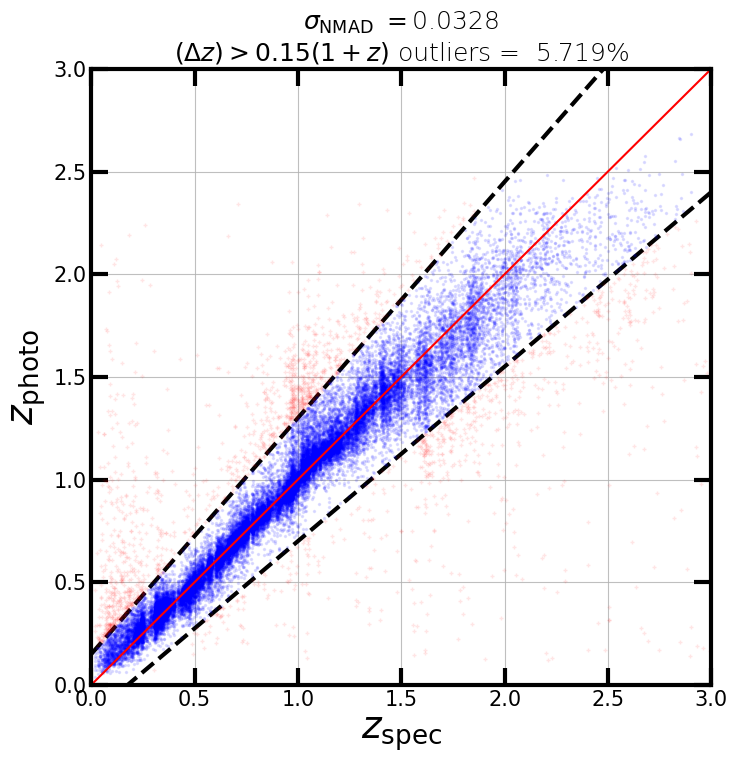

In [57]:
plot_and_stats(zspec,zphot)

Standard Deviation: 0.0926
Normalized MAD: 0.0328
Delta z >0.15(1+z) outliers:  5.719 percent
Median offset:  0.002 +/-  0.001


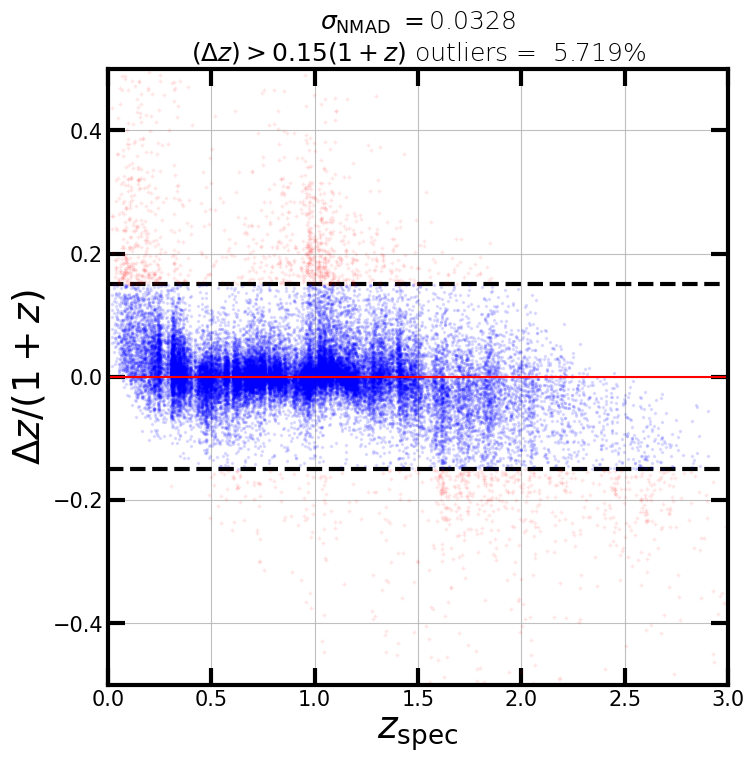

In [58]:
plot2_and_stats(zspec,zphot)

## Select Accurate sample

In [59]:
zphot= y_pred
zspec = y_test

In [60]:
denom = zspec.values + 1.
num = zphot-zspec.values
ratio = num/denom
select_flag = np.abs(ratio)<0.01

In [61]:
y_test_sel = y_test[select_flag]

In [62]:
len(select_flag)

35564

In [63]:
X_test["flag"] = select_flag

In [64]:
X_test_sel = X_test[X_test["flag"]]

In [65]:
len(X_test)

35564

In [66]:
X_test_sel.drop("flag",axis=1,inplace=True)

In [67]:
y_pred_sel =  regressor.predict(X_test_sel)

In [68]:
zphot= y_pred_sel
zspec = y_test_sel

Standard Deviation: 0.0055
Normalized MAD: 0.0069
Delta z >0.15(1+z) outliers:  0.000 percent
Median offset:  0.000 +/-  0.000


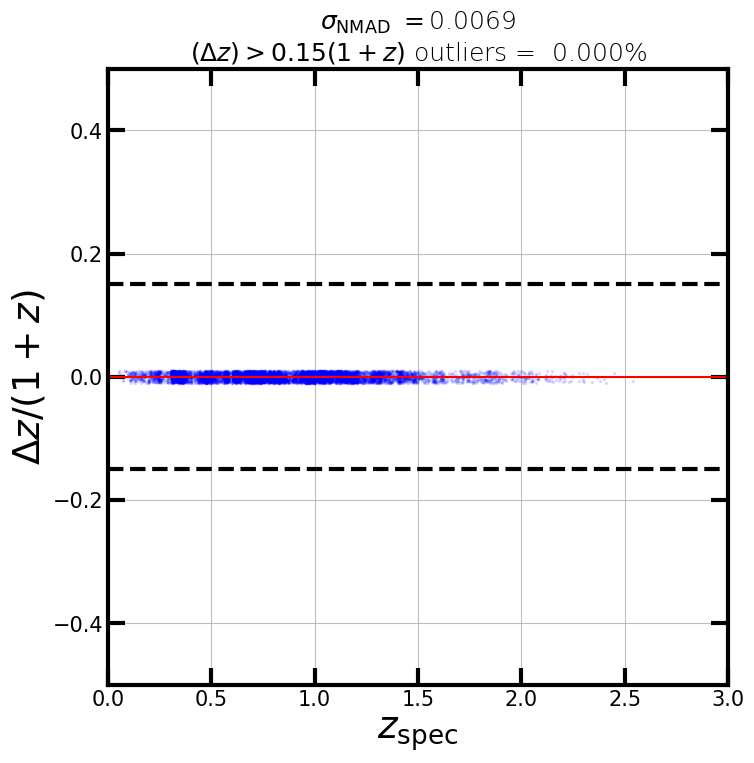

In [69]:
plot2_and_stats(zspec,zphot)

## Modify atmosphere

In [70]:
X_test_atm = X_test_sel.copy()

In [71]:
len(X_test_atm)

9883

### Change atmospheric conditions

In [72]:
X_test_atm["mag_u"] = X_test_atm["mag_u"] - delta["u"]
X_test_atm["mag_g"] = X_test_atm["mag_g"] - delta["g"]
X_test_atm["mag_r"] = X_test_atm["mag_r"] - delta["r"]
X_test_atm["mag_i"] = X_test_atm["mag_i"] - delta["i"]
X_test_atm["mag_z"] = X_test_atm["mag_z"] - delta["z"]
X_test_atm["mag_y"] = X_test_atm["mag_y"] - delta["y"]

In [73]:
y_pred_atm =  regressor.predict(X_test_atm)

In [74]:
r2  = r2_score(y_pred_atm,y_test_sel)
mae = mean_absolute_error(y_pred_atm,y_test_sel)
mse = mean_squared_error(y_pred_atm,y_test_sel)

In [75]:
msg_r2   = f"R2 score : \t\t {r2:.3f}"
msg_mae  = f"MAE mean absolute error : \t {mae:.3f}"
msg_rmsq = f"Root MSE error : \t\t {np.sqrt(mse):.3f}"

In [76]:
print(msg_r2)
print(msg_mae)
print(msg_rmsq)

R2 score : 		 0.992
MAE mean absolute error : 	 0.024
Root MSE error : 		 0.034


In [77]:
nmad,std_result,bias,eta,stats_txt2= get_stats(y_test_sel.values,y_pred_atm)

Standard Deviation: 0.0168
Normalized MAD: 0.0146
Delta z >0.15(1+z) outliers:  0.020 percent
Median offset: -0.005 +/-  0.000


In [78]:
zphot= y_pred_atm
zspec = y_test_sel

Standard Deviation: 0.0168
Normalized MAD: 0.0146
Delta z >0.15(1+z) outliers:  0.020 percent
Median offset: -0.005 +/-  0.000


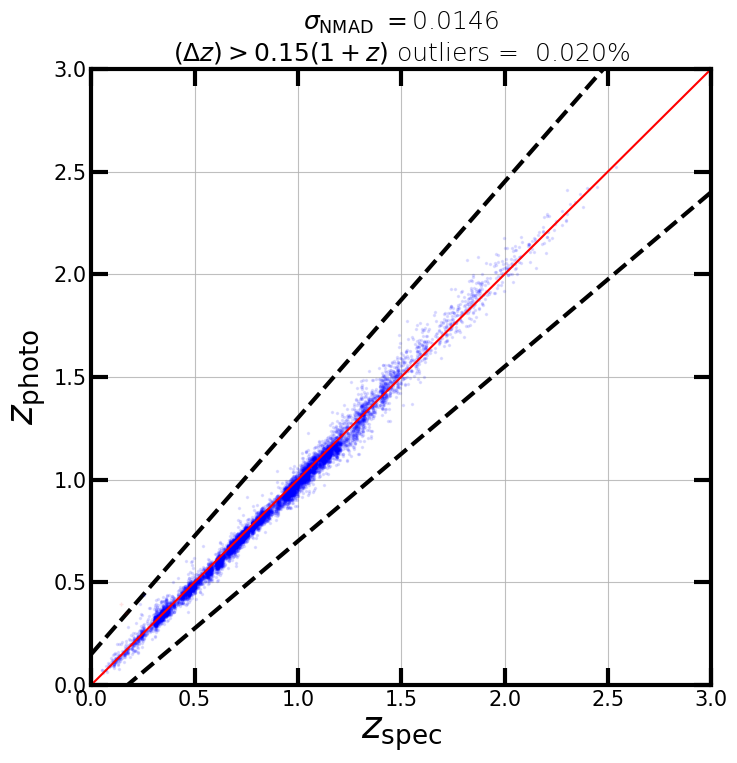

In [79]:
plot_and_stats(zspec,zphot)

Standard Deviation: 0.0168
Normalized MAD: 0.0146
Delta z >0.15(1+z) outliers:  0.020 percent
Median offset: -0.005 +/-  0.000


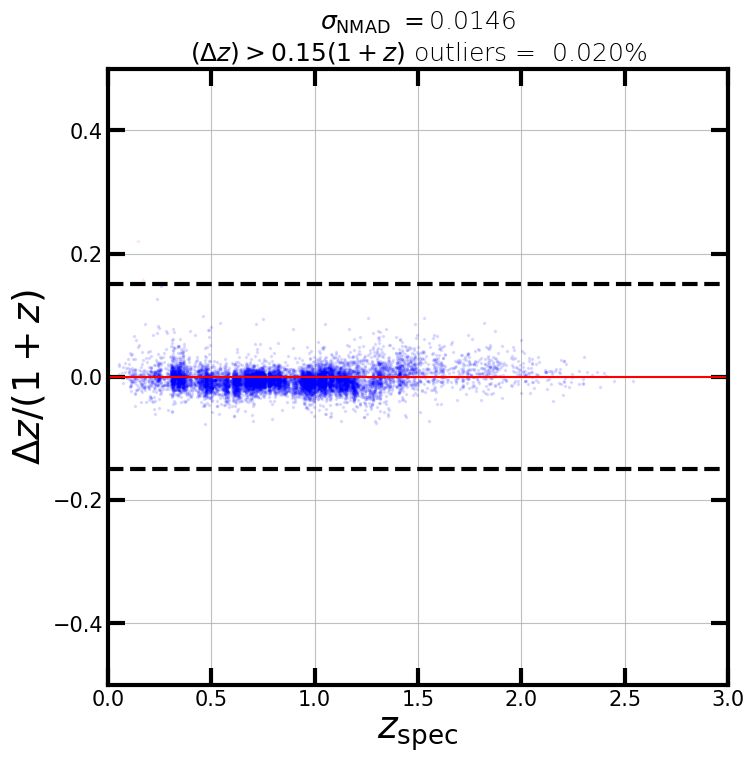

In [80]:
plot2_and_stats(zspec,zphot)